In [1]:
import matplotlib.pyplot as plt
import numpy as np

Check event generation

In [2]:
from generator import Response

In [3]:
from generator import OscPars

In [4]:
from generator import Generator

In [5]:
delta_msq_31 = 2.515e-3
sinsq_theta_23 = 0.565
# convert this to sin**2(2 \theta)
theta_23 = np.arcsin(np.sqrt(sinsq_theta_23))
sinsq_2theta_23 = np.sin(2 * theta_23)**2
default_pars = OscPars(delta_msq_31, sinsq_2theta_23)

default_response = Response(1., 0.05)

Plotting utility

In [6]:
def add_hist(fig, hist, label, **kwargs):
    # first and last bin are overflow bins in hist
    plt.stairs(hist['hist'][1:-1], hist['bin_edges'], label=label, **kwargs)
    plt.stairs(
        hist['hist'][1:-1] + hist['hist_unc'][1:-1],
        hist['bin_edges'],
        baseline=hist['hist'][1:-1] - hist['hist_unc'][1:-1],
        fill=True,
        alpha=0.5,
        **kwargs
    )


In [7]:
bin_edges = np.logspace(1., 2., 26)

### Just playing around with a couple of histograms

In [8]:
gen = Generator(int(1e5), default_response, default_pars)
h0 = gen.get_histogram(bin_edges)

Generating events with log10(E / GeV) from a Gaussian with mean 1.3 and wdith 0.5 and cos(zenith) values uniformly sampled between -1.0 and -1.0


In [9]:
gen_2 = Generator(int(1e5), default_response, OscPars(1.2 * default_pars.delta_mqs, default_pars.sinsq_2theta))
h2 = gen_2.get_histogram(bin_edges)

Generating events with log10(E / GeV) from a Gaussian with mean 1.3 and wdith 0.5 and cos(zenith) values uniformly sampled between -1.0 and -1.0


In [10]:
gen_3 = Generator(int(1e5), Response(1.2 * default_response.mu, default_response.sigma), default_pars)
h3 = gen_3.get_histogram(bin_edges)

Generating events with log10(E / GeV) from a Gaussian with mean 1.3 and wdith 0.5 and cos(zenith) values uniformly sampled between -1.0 and -1.0


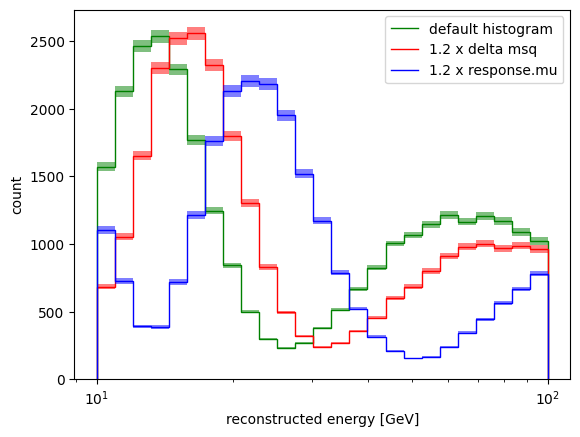

In [11]:
fig = plt.figure()

add_hist(fig, h0, 'default histogram', color='g')

add_hist(fig, h2, '1.2 x delta msq', color='r')

add_hist(fig, h3, '1.2 x response.mu', color='b')


plt.xscale('log')
plt.xlabel('reconstructed energy [GeV]')
plt.ylabel('count')

plt.legend()

Define systematic sets by their detector response, assuming the default oscillation parameters for now

In [12]:
default_response = Response(1., 0.05)

nevents = int(1e6)

In [13]:
variations = {
    'mu': {
        'baseline': 1.,
        'up': 1.05,
        'low': 0.95,
    }
}

responses = {
    "mu_baseline": Response(variations['mu']['baseline'] * default_response.mu, default_response.sigma),
    "mu_up": Response(variations['mu']['up'] * default_response.mu, default_response.sigma),
    "mu_low": Response(variations['mu']['low'] * default_response.mu, default_response.sigma),
}

# assume default oscillation parameters for now
sets = {k: Generator(nevents, r, default_pars) for k,r in responses.items()}



Generating events with log10(E / GeV) from a Gaussian with mean 1.3 and wdith 0.5 and cos(zenith) values uniformly sampled between -1.0 and -1.0
Generating events with log10(E / GeV) from a Gaussian with mean 1.3 and wdith 0.5 and cos(zenith) values uniformly sampled between -1.0 and -1.0
Generating events with log10(E / GeV) from a Gaussian with mean 1.3 and wdith 0.5 and cos(zenith) values uniformly sampled between -1.0 and -1.0


In [14]:
variations

{'mu': {'baseline': 1.0, 'up': 1.05, 'low': 0.95}}

In [15]:
sets

{'mu_baseline': <generator.Generator at 0x156437280>,
 'mu_up': <generator.Generator at 0x12ffbc040>,
 'mu_low': <generator.Generator at 0x10897ff40>}

Toy analysis using these discrete sets, so far only gradients in $\mu$ are calculated for testing

In [16]:
class ToyAnalysis():

    def __init__(self, sets, variations, binning) -> None:

        self.__sets = sets

        self.__binning = binning

        # pick one of the baseline sets
        self.__baseline_set = [s for k, s in sets.items() if "baseline" in k][0]

        self.__baseline_reponse = self.__baseline_set.get_detector_response()
        self.__default_pars = self.__baseline_set.get_oscillation_pars()

        self.__make_gradients(variations)

    def __make_gradients(self, variations):

        gradients_histogram = {}
        # naive way of calculating finite difference: G = (hist_up - hist_low) / delta_par
        # TODO: include statistical uncertainties?
        for par, vals in variations.items():
            
            hist_up = self.__sets[par+'_up'].get_histogram(self.__binning)['hist']
            hist_low = self.__sets[par+'_low'].get_histogram(self.__binning)['hist']
            delta_par = vals['up'] - vals['low']

            gradients_histogram[par] = (hist_up - hist_low) / delta_par

        self.__gradients = gradients_histogram
        
    def get_histogram(self, response, osc_pars):
        # reweight baseline set to oscillation parameters
        self.__baseline_set.reweight_oscillation(osc_pars)
        hist_base = self.__baseline_set.get_histogram(self.__binning)['hist']
        hist_base_unc = self.__baseline_set.get_histogram(self.__binning)['hist_unc']

        # not strictly necessary: re-set generator of baseline set to default oscillation pars
        self.__baseline_set.reweight_oscillation(self.__default_pars)

        # apply gradients:
        print("Warning: Only gradients with respect to 'mu' are implemeted so far")
        # TODO otherwise: loop over parameters...
        hist_final = hist_base + (response.mu - self.__baseline_reponse.mu) * self.__gradients['mu']

        # return histogram in full format (see Generator), statistical uncertainties from gradients not yet included...
        return {'hist': hist_final, 'hist_unc': hist_base_unc, 'bin_edges': self.__binning}



In [17]:
analysis = ToyAnalysis(sets, variations, bin_edges)

## Compare target histograms for generated set and gradient approximation:

### Default oscillation parameters

In [18]:
target_response = Response(1.03 * default_response.mu, default_response.sigma)
target_pars = OscPars(1. * default_pars.delta_mqs, default_pars.sinsq_2theta)

Generating events with log10(E / GeV) from a Gaussian with mean 1.3 and wdith 0.5 and cos(zenith) values uniformly sampled between -1.0 and -1.0


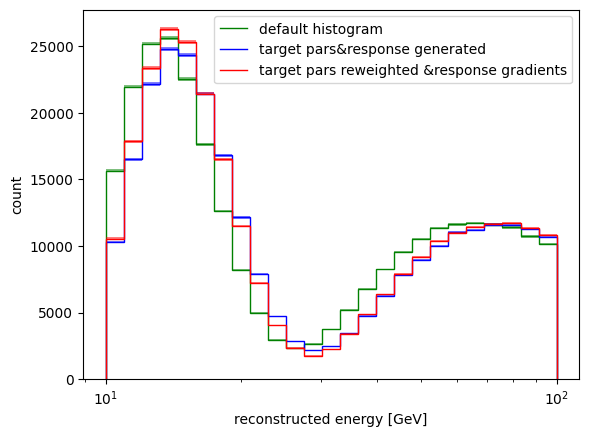

In [19]:
fig = plt.figure()

add_hist(fig, sets['mu_baseline'].get_histogram(bin_edges),
    'default histogram', color='g')

add_hist(fig, Generator(nevents, target_response, target_pars).get_histogram(bin_edges),
    'target pars&response generated', color='b')

add_hist(fig, analysis.get_histogram(target_response, target_pars),
    'target pars reweighted &response gradients', color='r')


plt.xscale('log')
plt.xlabel('reconstructed energy [GeV]')
plt.ylabel('count')

plt.legend()

### Non-default oscillation parameters: larger mass splitting

In [20]:
target_response = Response(1.03 * default_response.mu, default_response.sigma)
target_pars = OscPars(1.3 * default_pars.delta_mqs, default_pars.sinsq_2theta)

Generating events with log10(E / GeV) from a Gaussian with mean 1.3 and wdith 0.5 and cos(zenith) values uniformly sampled between -1.0 and -1.0


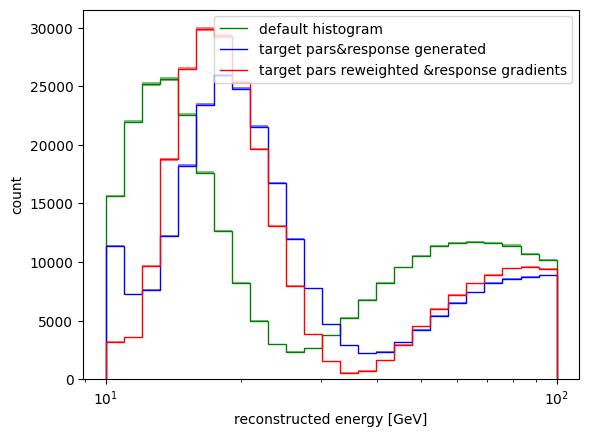

In [21]:
fig = plt.figure()

add_hist(fig, sets['mu_baseline'].get_histogram(bin_edges),
    'default histogram', color='g')

add_hist(fig, Generator(nevents, target_response, target_pars).get_histogram(bin_edges),
    'target pars&response generated', color='b')

add_hist(fig, analysis.get_histogram(target_response, target_pars),
    'target pars reweighted &response gradients', color='r')


plt.xscale('log')
plt.xlabel('reconstructed energy [GeV]')
plt.ylabel('count')

plt.legend()